In [ ]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

nexus_file = "/SNS/VENUS/IPTS-34969/nexus/VENUS_7703.nxs.h5"

with h5py.File(nexus_file, 'r') as hdf5_data:
    event_time_offset_original = hdf5_data['entry']['bank100_events']['event_time_offset'][:]
    event_id_original = hdf5_data['entry']['bank100_events']['event_id'][:]

offset_value = 1000000  # Offset value
event_id_original -= offset_value

# DEBUGGING: Work with only the first n events
n_events = min(len(event_time_offset_original), 300000000)
event_time_offset = event_time_offset_original[:n_events]
event_id = event_id_original[:n_events]

hist, bin_edges = np.histogram(event_time_offset, bins=1000, range=(0, 16667))

number_of_pixels_per_chip = int(512 * 512 / 4)
print(f"number_of_pixels_per_chip = {number_of_pixels_per_chip}")

# Define bank ranges
banks = {
    0: {'from': 0, 'to': number_of_pixels_per_chip - 1},
    1: {'from': number_of_pixels_per_chip, 'to': 2 * number_of_pixels_per_chip - 1},
    2: {'from': 2 * number_of_pixels_per_chip, 'to': 3 * number_of_pixels_per_chip - 1},
    3: {'from': 3 * number_of_pixels_per_chip, 'to': 4 * number_of_pixels_per_chip - 1}
}

# Determine bank IDs for all event IDs
list_of_banks_pixelid_belongs_to = np.zeros_like(event_id, dtype=np.uint8)
list_of_banks_pixelid_belongs_to[event_id < banks[0]['to']] = 0
list_of_banks_pixelid_belongs_to[(event_id >= banks[1]['from']) & (event_id < banks[1]['to'])] = 1
list_of_banks_pixelid_belongs_to[(event_id >= banks[2]['from']) & (event_id < banks[2]['to'])] = 2
list_of_banks_pixelid_belongs_to[event_id >= banks[3]['from']] = 3

# Vectorized mapping functions
def map_pixels_to_coordinates(event_id, bank_id):
    pixel_id = event_id.copy()
    row, col = None, None

    # if bank_id == 0:
    #     row = pixel_id % 256
    #     col = 255 - (pixel_id // 256) + 256
    # elif bank_id == 1:
    #     pixel_id -= 256 * 256
    #     row = pixel_id % 256
    #     col = 255 - (pixel_id // 256)
    if bank_id == 2:
        pixel_id -= 2 * 256 * 256
        row = 511 - (pixel_id % 256)
        col = pixel_id // 256
    # elif bank_id == 3:
    #     pixel_id -= 3 * 256 * 256
    #     row = 511 - (pixel_id % 256)
    #     col = (pixel_id // 256) + 256

    return row, col

# Initialize the full image
full_image = np.zeros((512, 512), dtype=np.int32)

# Vectorized processing for each bank
for bank_id in range(4):
    mask = list_of_banks_pixelid_belongs_to == bank_id
    bank_event_ids = event_id[mask]
    rows, cols = map_pixels_to_coordinates(bank_event_ids, bank_id)
    np.add.at(full_image, (rows, cols), 1)

number_of_pixels_per_chip = 65536


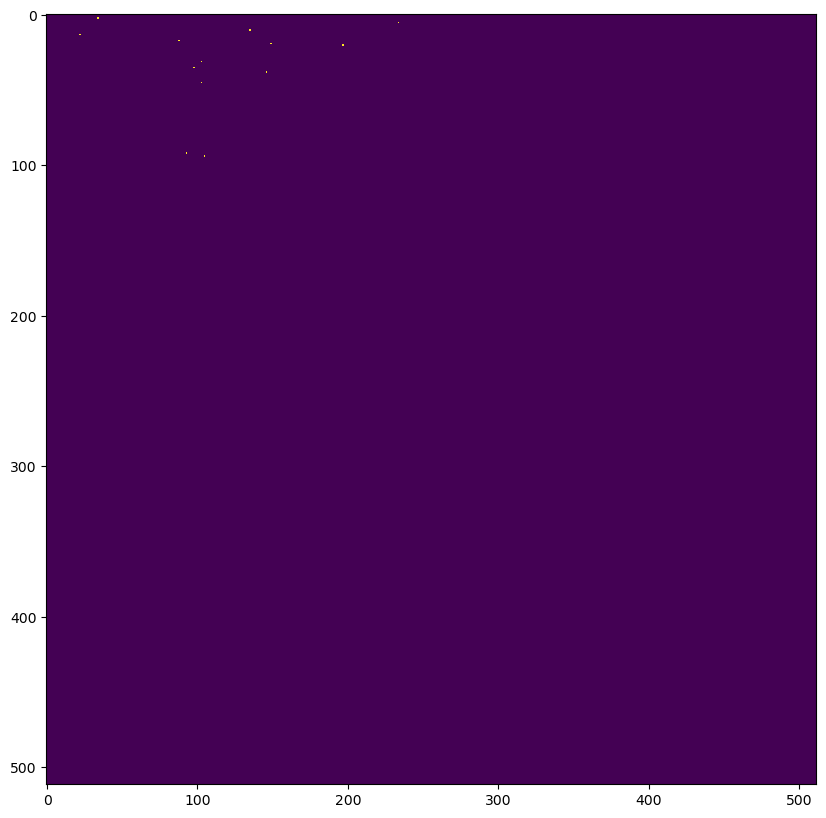

In [6]:
plt.figure(0, figsize=(10,10))
plt.imshow(full_image, cmap='viridis', interpolation='nearest')